In [1]:
import pandas as pd

df_train = pd.read_csv('train.csv',index_col='Id')
df_test = pd.read_csv('test.csv',index_col='Id')

maxid_train = max(df_train.index)

df_all = pd.concat([df_train,df_test])
df_all.head(5)

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
2,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
3,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
4,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
5,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


In [2]:
# summary of columns with nan values
cols_with_na = df_all.isnull().sum()
cols_with_na = cols_with_na[cols_with_na>0]
print(cols_with_na.sort_values(ascending=False))

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Electrical         1
BsmtUnfSF          1
Exterior1st        1
Exterior2nd        1
TotalBsmtSF        1
GarageCars         1
BsmtFinSF2         1
BsmtFinSF1         1
KitchenQual        1
SaleType           1
GarageArea         1
dtype: int64


In [3]:
# columns where NaN values have meaning e.g. no pool etc.
cols_fillna = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2']

for col in cols_fillna:
    df_all[col].fillna('None',inplace=True)

In [4]:
# remaining nan values (SalePrice nans are training data)
cols_with_na = df_all.isnull().sum()
cols_with_na = cols_with_na[cols_with_na>0]
print(cols_with_na.sort_values(ascending=False))

SalePrice       1459
LotFrontage      486
GarageYrBlt      159
MasVnrArea        23
MSZoning           4
Utilities          2
BsmtFullBath       2
BsmtHalfBath       2
Functional         2
Exterior1st        1
BsmtFinSF2         1
BsmtUnfSF          1
Electrical         1
GarageArea         1
Exterior2nd        1
TotalBsmtSF        1
GarageCars         1
KitchenQual        1
SaleType           1
BsmtFinSF1         1
dtype: int64


In [5]:
# convert some categorical values to numeric scales

#Excellent, Good, Typical, Fair, Poor: Convert to 1-5 scale
cols_ExGd = ['ExterQual','ExterCond','BsmtQual','BsmtCond',
             'HeatingQC','KitchenQual','FireplaceQu','GarageQual',
            'GarageCond','PoolQC']

dict_ExGd = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0}

for col in cols_ExGd:
    df_all[col].replace(dict_ExGd, inplace=True)

# Remaining columns

df_all['BsmtExposure'].replace({'Gd':4,'Av':3,'Mn':2,'No':1,'None':0}, inplace=True)

df_all['BsmtFinType1'].replace({'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'None':0}, inplace=True)
df_all['BsmtFinType2'].replace({'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'None':0}, inplace=True)

df_all['CentralAir'].replace({'Y':1,'N':0}, inplace=True)

df_all['Functional'].replace({'Typ':7,'Min1':6,'Min2':5,'Mod':4,'Maj1':3,'Maj2':2,'Sev':1,'Sal':0}, inplace=True)

df_all['GarageFinish'].replace({'Fin':3,'RFn':2,'Unf':1,'None':0}, inplace=True)

df_all['LotShape'].replace({'Reg':3,'IR1':2,'IR2':1,'IR3':0}, inplace=True)

df_all['Utilities'].replace({'AllPub':3,'NoSewr':2,'NoSeWa':1,'ELO':0}, inplace=True)

df_all['LandSlope'].replace({'Gtl':2,'Mod':1,'Sev':0}, inplace=True)

In [6]:
df_all.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1,856,854,0,None,3,1Fam,3,1,706.0,0.0,...,WD,0,Pave,8,856.0,3.0,0,2003,2003,2008
2,1262,0,0,None,3,1Fam,3,4,978.0,0.0,...,WD,0,Pave,6,1262.0,3.0,298,1976,1976,2007
3,920,866,0,None,3,1Fam,3,2,486.0,0.0,...,WD,0,Pave,6,920.0,3.0,0,2001,2002,2008
4,961,756,0,None,3,1Fam,4,1,216.0,0.0,...,WD,0,Pave,7,756.0,3.0,0,1915,1970,2006
5,1145,1053,0,None,4,1Fam,3,3,655.0,0.0,...,WD,0,Pave,9,1145.0,3.0,192,2000,2000,2008


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


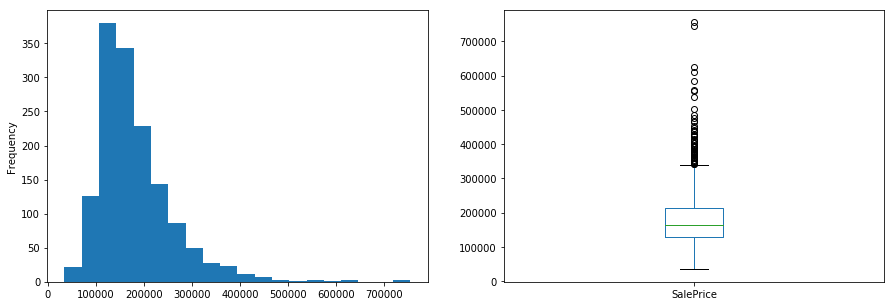

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

print(df_all.SalePrice.describe())

plt.figure(figsize=(15,5))
ax=plt.subplot(1,2,1)
df_all.SalePrice.plot.hist(bins=20,ax=ax)
ax=plt.subplot(1,2,2)
df_all.SalePrice.plot.box(ax=ax)

count    1460.000000
mean       12.024051
std         0.399452
min        10.460242
25%        11.775097
50%        12.001505
75%        12.273731
max        13.534473
Name: SalePrice, dtype: float64


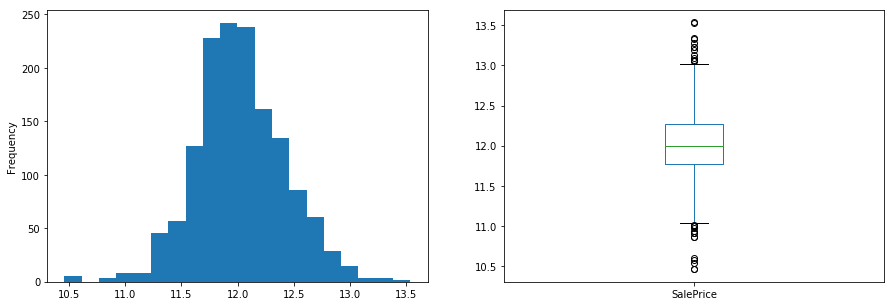

In [8]:
# log transform sale price - more normally distributed
import numpy as np

df_all.SalePrice = np.log(df_all.SalePrice)

'''
#remove some outliers
print('------------------')
print('3-sigma outliers log(SalePrice):')

nstd = abs(df_all.SalePrice - df_all.SalePrice.mean())/df_all.SalePrice.std()
nstd.name = 'nstd'

outlier_sp = df_all.SalePrice[nstd>3]

display(pd.merge(df_all.loc[outlier_sp.index,['SalePrice','YearBuilt','LotArea','GrLivArea','OverallQual','MSZoning','Neighborhood']],
               pd.DataFrame(nstd),how='left',left_index=True,right_index=True))

df_all.drop(outlier_sp.index,inplace=True)

print('Dropped',len(outlier_sp),'log(SalePrice) outliers')
print('------------------')
'''

print(df_all.SalePrice.describe())

plt.figure(figsize=(15,5))
ax=plt.subplot(1,2,1)
df_all.SalePrice.plot.hist(bins=20,ax=ax)
ax=plt.subplot(1,2,2)
df_all.SalePrice.plot.box(ax=ax)

In [9]:
dtypes = df_all.dtypes
cols_numeric = dtypes[dtypes != object].index.tolist()

# MSubClass values should be treated as categories instead
cols_numeric.remove('MSSubClass')

print(len(cols_numeric),'numeric columns')

55 numeric columns


In [10]:
cols_categ = dtypes[~dtypes.index.isin(cols_numeric)].index.tolist()

#for col in cols_categ:
#    df_all[col] = df_all[col].astype('category')
    
print(len(cols_categ),'categorical columns')

25 categorical columns


In [11]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 80 columns):
1stFlrSF         2919 non-null int64
2ndFlrSF         2919 non-null int64
3SsnPorch        2919 non-null int64
Alley            2919 non-null object
BedroomAbvGr     2919 non-null int64
BldgType         2919 non-null object
BsmtCond         2919 non-null int64
BsmtExposure     2919 non-null int64
BsmtFinSF1       2918 non-null float64
BsmtFinSF2       2918 non-null float64
BsmtFinType1     2919 non-null int64
BsmtFinType2     2919 non-null int64
BsmtFullBath     2917 non-null float64
BsmtHalfBath     2917 non-null float64
BsmtQual         2919 non-null int64
BsmtUnfSF        2918 non-null float64
CentralAir       2919 non-null int64
Condition1       2919 non-null object
Condition2       2919 non-null object
Electrical       2918 non-null object
EnclosedPorch    2919 non-null int64
ExterCond        2919 non-null int64
ExterQual        2919 non-null int64
Exterior1st      2918 non-n

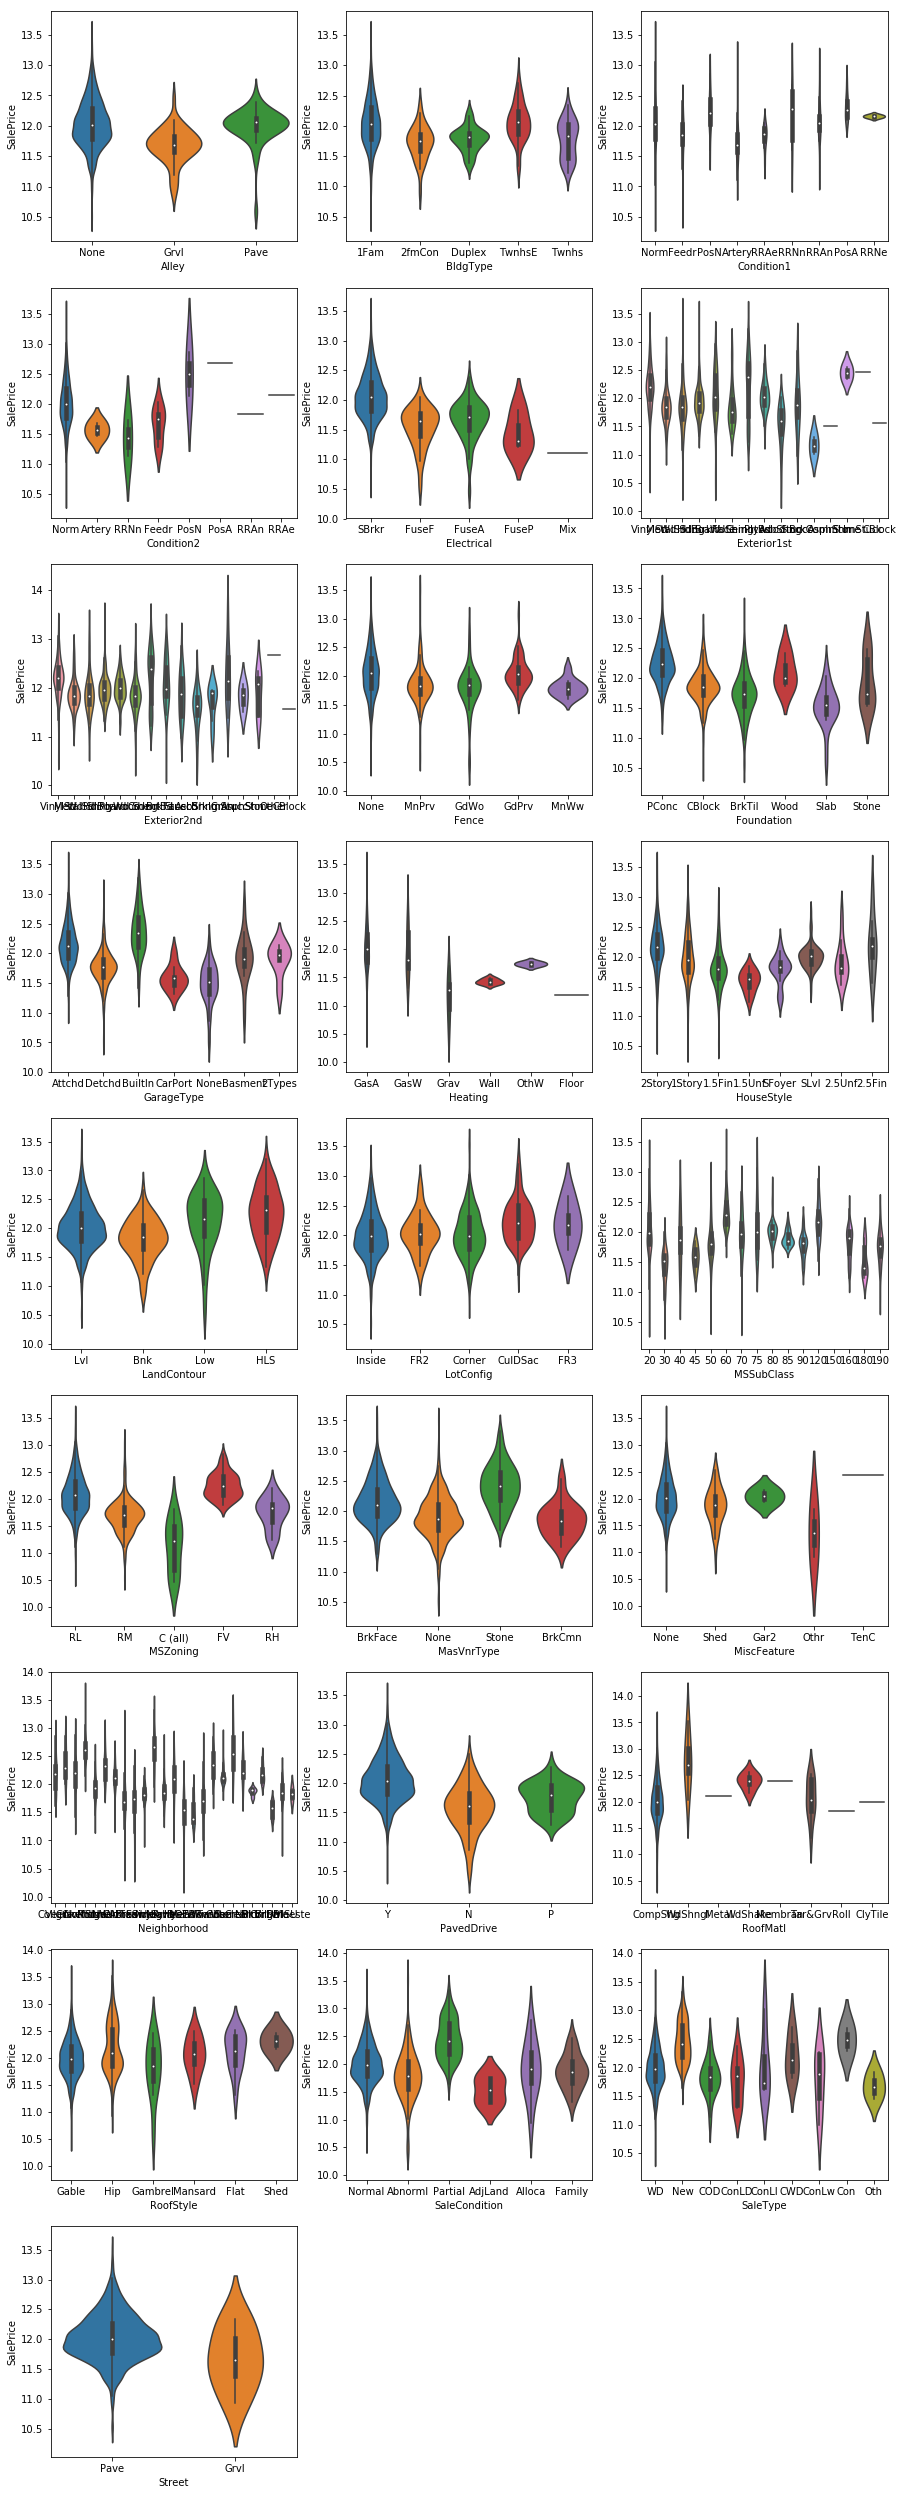

In [12]:
# plot categorical variables

from math import ceil
import seaborn as sns

fcols = 3
frows = ceil(len(cols_categ)/fcols)
plt.figure(figsize=(15,5*frows))

for i,col in enumerate(cols_categ):
    plt.subplot(frows,fcols,i+1)
    sns.violinplot(df_all[col],df_all['SalePrice'])

In [13]:
# anova test to check significance of variation between groups

from scipy import stats

def anova(group,value):
    # select columns of interest, and remove any rows with nan values
    data = df_all[[group,value]]
    data = data[~(data[group].isnull() | data[value].isnull())]
    
    # stats across all data
    tot_groups = data[group].nunique() # no. of groups
    len_data = len(data) # total sample size of house (all groups)
    mean_data = data[value].mean() # mean across all groups
    df_betwn = tot_groups - 1 # degrees of freedom betwn grps
    df_within = len_data - tot_groups # degrees of freedom within grps
    
    # per group stats
    n_in_group = data.groupby(group)[value].count() # no. houses in group
    mean_group = data.groupby(group)[value].mean() # mean value in this group
    
    # between-group variability
    betwn_var = n_in_group*((mean_group - mean_data)**2)
    betwn_var = float(betwn_var.sum())/df_betwn
    
    # within-group variability
    within_var = 0
    for grp in data[group].unique():
        samples = data.loc[data[group]==grp, value]
        within_var += ((samples-mean_group[grp])**2).sum()
        
    within_var = float(within_var)/df_within
    
    #F-test statistic
    F = betwn_var/within_var
    
    # p-value
    p = stats.f.sf(F, df_betwn, df_within)
    
    return p
        

In [14]:
# check significance of categorical variables on SalePrice
p_col = dict()

for col in cols_categ:
    p_col[col] = anova(col,'SalePrice')
    
pd.Series(p_col).sort_values()

Neighborhood     4.043304e-243
GarageType       8.427845e-125
MSSubClass       5.096023e-115
Foundation       1.350671e-111
MasVnrType        1.670061e-65
MSZoning          1.021343e-59
Exterior1st       1.053128e-53
Exterior2nd       2.429938e-49
SaleCondition     1.689708e-41
SaleType          5.497893e-36
PavedDrive        1.090995e-31
Electrical        6.370516e-31
HouseStyle        1.636077e-30
Fence             6.560319e-13
RoofStyle         1.705740e-12
BldgType          3.436794e-12
Condition1        1.173444e-10
Alley             1.358108e-09
Heating           2.484312e-09
LandContour       3.086224e-08
LotConfig         6.214575e-07
RoofMatl          4.504239e-04
MiscFeature       6.059928e-03
Condition2        1.382042e-02
Street            2.837931e-02
dtype: float64

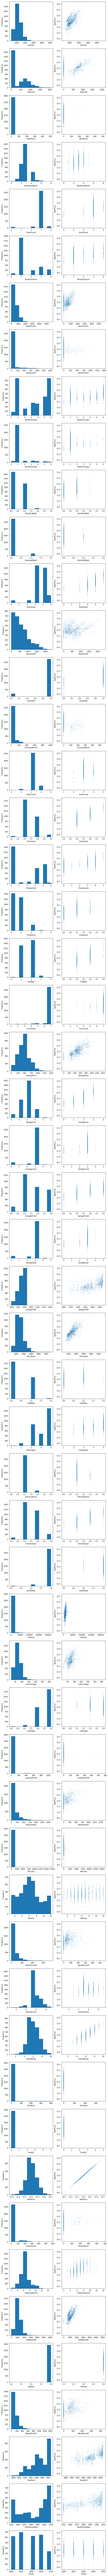

In [15]:
# plot numeric values

fcols = 2
frows = len(cols_numeric)
plt.figure(figsize=(5*fcols,5*frows))

i=0
for col in cols_numeric:
    i+=1
    ax=plt.subplot(frows,fcols,i)
    df_all[col].plot.hist(ax=ax)
    plt.xlabel(col)
    
    i+=1
    ax=plt.subplot(frows,fcols,i)
    df_all.plot.scatter(x=col,y='SalePrice',s=2,alpha=0.25,ax=ax)
    plt.xlabel(col)
    plt.ylabel('SalePrice')

SalePrice        1.000000
OverallQual      0.809829
GrLivArea        0.731310
GarageCars       0.690711
ExterQual        0.684014
BsmtQual         0.678026
KitchenQual      0.672849
YearBuilt        0.652682
GarageArea       0.649379
FullBath         0.635957
GarageFinish     0.633974
TotalBsmtSF      0.602725
GarageYrBlt      0.593788
1stFlrSF         0.575408
YearRemodAdd     0.571159
FireplaceQu      0.537602
TotRmsAbvGrd     0.532586
Fireplaces       0.519247
HeatingQC        0.491392
OpenPorchSF      0.477561
LotArea          0.456461
MasVnrArea       0.421309
LotFrontage      0.409076
BsmtFinType1     0.361625
WoodDeckSF       0.353802
GarageQual       0.351082
BsmtExposure     0.344207
HalfBath         0.343008
GarageCond       0.339015
LotShape         0.321055
CentralAir       0.313286
BsmtFinSF1       0.301871
2ndFlrSF         0.293598
BsmtCond         0.269373
BedroomAbvGr     0.234907
BsmtFullBath     0.225125
EnclosedPorch    0.218394
BsmtUnfSF        0.185197
KitchenAbvGr

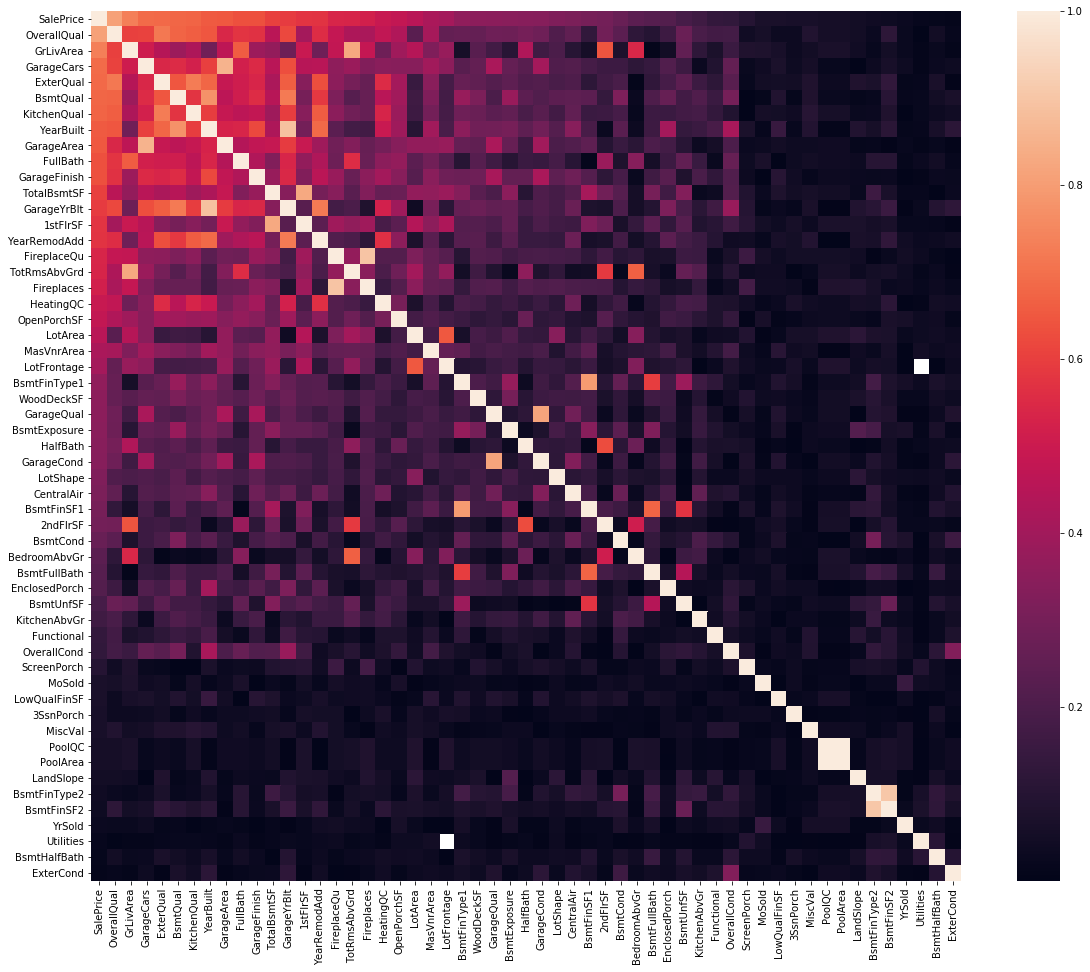

In [33]:
# correlation between numeric variables
df_corr = df_all.loc[df_all.index <= maxid_train, cols_numeric].corr(method='spearman').abs()

# order columns and rows by correlation with SalePrice
df_corr = df_corr.sort_values('SalePrice',axis=0,ascending=False).sort_values('SalePrice',axis=1,ascending=False)

print(df_corr.SalePrice)

ax=plt.figure(figsize=(20,16)).gca()
sns.heatmap(df_corr,ax=ax,square=True)

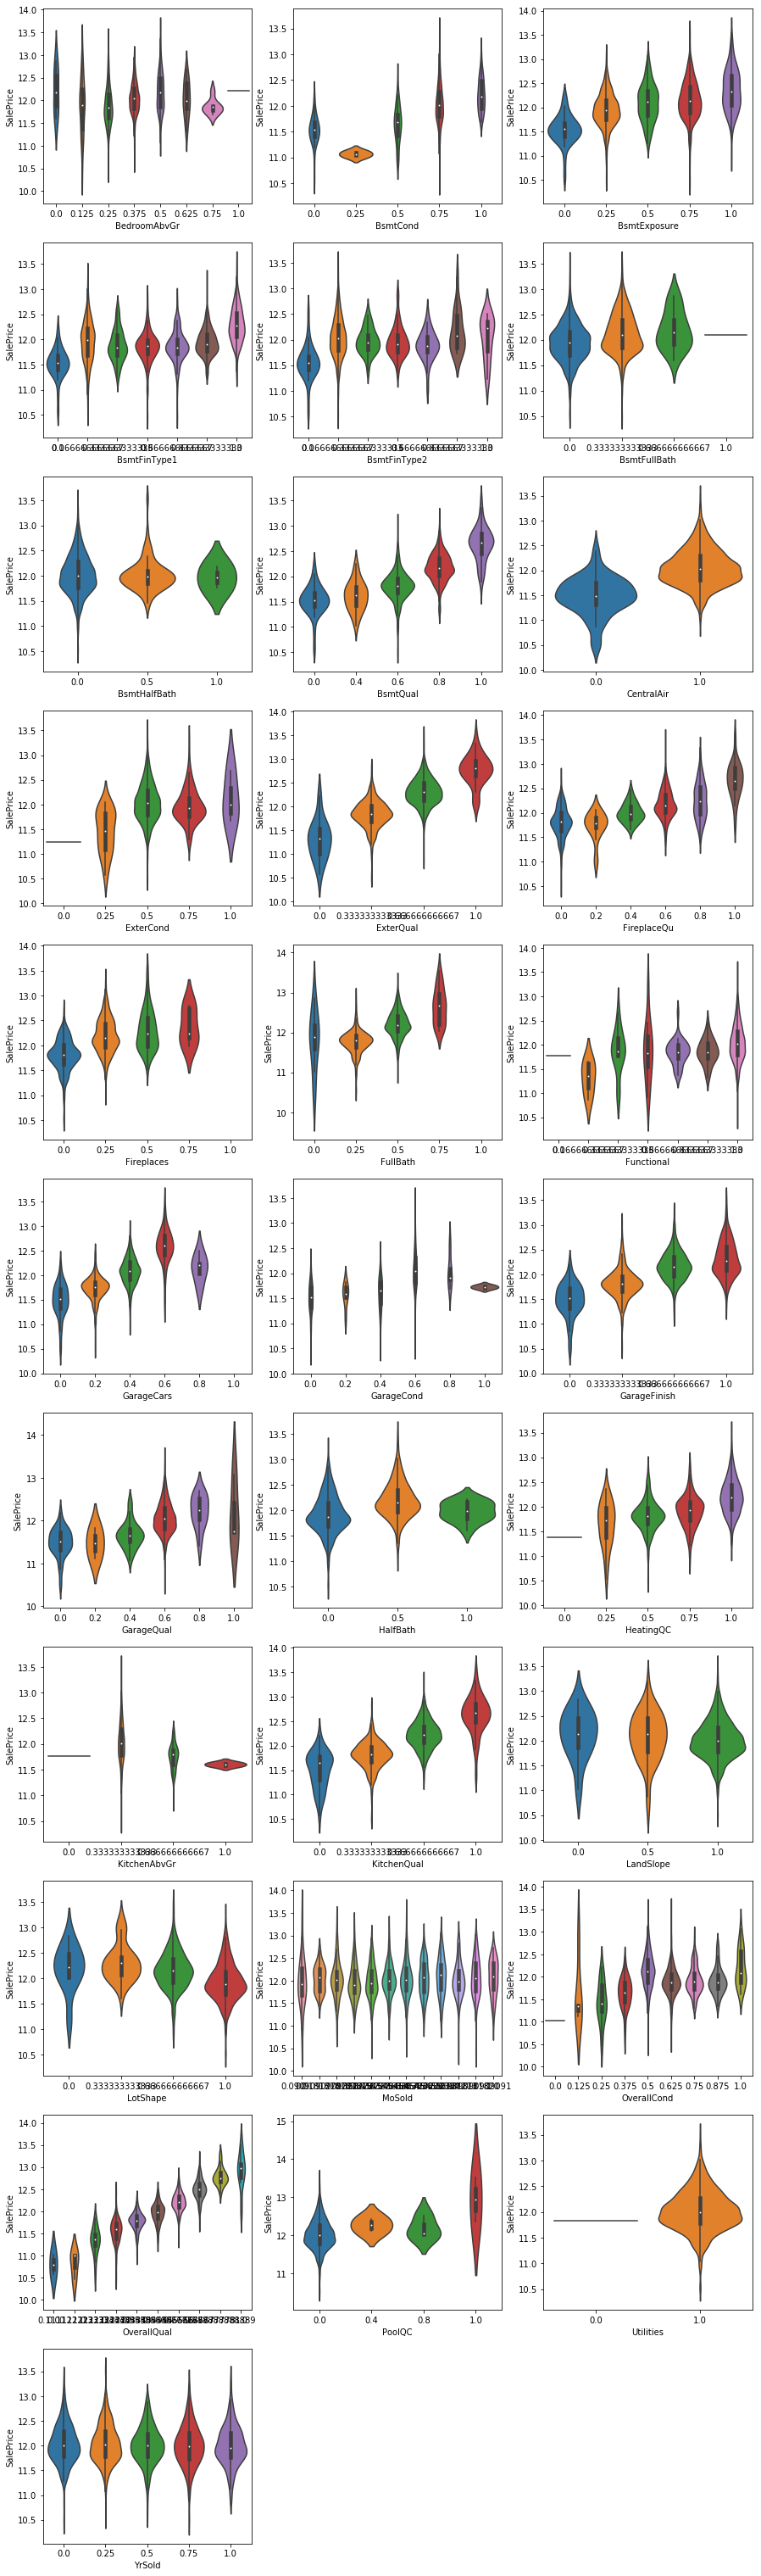

In [34]:
# numeric columns with few values
col_nunique = dict()

for col in cols_numeric:
    col_nunique[col] = df_all[col].nunique()
    
col_nunique = pd.Series(col_nunique)

cols_numcat = col_nunique[col_nunique<13].index.tolist()

fcols = 3
frows = ceil(len(cols_numcat)/fcols)
plt.figure(figsize=(15,5*frows))

for i,col in enumerate(cols_numcat):
    plt.subplot(frows,fcols,i+1)
    sns.violinplot(df_all[col],df_all['SalePrice'])

In [35]:
p_col = dict()

for col in cols_numcat:
    p_col[col] = anova(col,'SalePrice')
    
pd.Series(p_col).sort_values()

OverallQual      0.000000e+00
GarageCars      5.539585e-211
ExterQual       6.935425e-195
BsmtQual        2.031282e-188
KitchenQual     4.441486e-187
GarageFinish    4.057458e-151
FullBath        8.569577e-142
FireplaceQu     6.963458e-115
Fireplaces       7.485912e-97
HeatingQC        1.614882e-82
BsmtFinType1     4.321404e-78
OverallCond      9.270535e-53
GarageCond       2.508058e-47
BsmtExposure     2.590707e-47
GarageQual       6.068406e-46
CentralAir       9.855628e-44
HalfBath         1.323217e-37
LotShape         7.856968e-29
BsmtCond         1.492754e-27
BedroomAbvGr     2.473588e-20
BsmtFullBath     1.424832e-18
ExterCond        6.540305e-14
BsmtFinType2     5.805632e-12
KitchenAbvGr     1.787541e-07
Functional       4.250370e-06
PoolQC           7.695551e-03
LandSlope        3.388375e-01
MoSold           4.496616e-01
YrSold           5.656374e-01
Utilities        6.296094e-01
BsmtHalfBath     9.695381e-01
dtype: float64

In [19]:
'''
# Columns with low impact on SalePrice 
#(less than 10% correlation, or greater than 0.01 p-value)

cols_lowimpact = ['MoSold','YrSold','BsmtHalfBath',
                  'PoolArea','OverallCond','3SsnPorch',
                  'LowQualFinSF','MiscVal','BsmtFinSF2',
                  'RoofMatl','Street','LandSlope','PoolQC',          
                  'Utilities']
'''

"\n# Columns with low impact on SalePrice \n#(less than 10% correlation, or greater than 0.01 p-value)\n\ncols_lowimpact = ['MoSold','YrSold','BsmtHalfBath',\n                  'PoolArea','OverallCond','3SsnPorch',\n                  'LowQualFinSF','MiscVal','BsmtFinSF2',\n                  'RoofMatl','Street','LandSlope','PoolQC',          \n                  'Utilities']\n"

In [20]:
'''
# drop columns with little impact on SalePrice
df_all.drop(cols_lowimpact,axis=1,inplace=True)

cols_numeric = [col for col in cols_numeric if col not in cols_lowimpact]
cols_categ = [col for col in cols_categ if col not in cols_lowimpact]
cols_numcat = [col for col in cols_numcat if col not in cols_lowimpact]
'''

'\n# drop columns with little impact on SalePrice\ndf_all.drop(cols_lowimpact,axis=1,inplace=True)\n\ncols_numeric = [col for col in cols_numeric if col not in cols_lowimpact]\ncols_categ = [col for col in cols_categ if col not in cols_lowimpact]\ncols_numcat = [col for col in cols_numcat if col not in cols_lowimpact]\n'

In [36]:
# max correlation between variable and another variable
#for col in df_corr.columns:
#    print(col,':',df_corr[col].drop(col).max(),'in',df_corr[col].drop(col).idxmax())

# max correlation between variable and other variables with higher correlation with sale price
print('-------------------------------------------------------')    
for i in range(2,len(df_corr)):
    print(df_corr.columns[i],':',df_corr.iloc[i,1:i].max(),'in',df_corr.iloc[i,1:i].idxmax())


#10 vars with high correlation with saleprice but no correlations >0.8 with each other:
#OverallQual 
#GrLivArea 
#GarageCars 
#YearBuilt 
#FullBath 
#TotalBsmtSF 
#YearRemodAdd 
#Fireplaces 
#OpenPorchSF
#LotArea 

#ExterQual
#BsmtQual
#KitchenQual
#GarageFinish
#FireplaceQu
#HeatingQC


-------------------------------------------------------
GrLivArea : 0.603262358227 in OverallQual
GarageCars : 0.608755616437 in OverallQual
ExterQual : 0.71598823083 in OverallQual
BsmtQual : 0.67304812939 in OverallQual
KitchenQual : 0.725266498019 in ExterQual
YearBuilt : 0.774373415203 in BsmtQual
GarageArea : 0.853317376608 in GarageCars
FullBath : 0.658419243884 in GrLivArea
GarageFinish : 0.620329480864 in YearBuilt
TotalBsmtSF : 0.486685440256 in GarageArea
GarageYrBlt : 0.890546387209 in YearBuilt
1stFlrSF : 0.829291930357 in TotalBsmtSF
YearRemodAdd : 0.722376982085 in GarageYrBlt
FireplaceQu : 0.481197495951 in OverallQual
TotRmsAbvGrd : 0.827874323116 in GrLivArea
Fireplaces : 0.895131473194 in FireplaceQu
HeatingQC : 0.563356164338 in YearRemodAdd
OpenPorchSF : 0.435046311071 in OverallQual
LotArea : 0.449039505613 in GrLivArea
MasVnrArea : 0.413500036665 in OverallQual
LotFrontage : 0.649632968379 in LotArea
BsmtFinType1 : 0.375364282654 in BsmtQual
WoodDeckSF : 0.3155729

In [22]:
# normalise numeric columns
def scale_minmax(col):
    return (col-col.min())/(col.max()-col.min())

scale_cols = [col for col in cols_numeric if col!='SalePrice']

df_all[scale_cols] = df_all[scale_cols].apply(scale_minmax,axis=0)

df_all[scale_cols].describe()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,...,PoolArea,PoolQC,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
count,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2918.000000,2918.000000,2919.000000,2919.000000,...,2919.000000,2919.000000,2919.000000,2919.000000,2918.000000,2917.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,0.173405,0.162946,0.005123,0.357528,0.729616,0.405961,0.078211,0.032492,0.590271,0.212287,...,0.002815,0.002741,0.027886,0.342425,0.172140,0.999657,0.065807,0.719658,0.571075,0.448184
std,0.082412,0.207604,0.049583,0.102837,0.143737,0.267506,0.080725,0.110882,0.352309,0.159197,...,0.044580,0.048480,0.097542,0.120721,0.072139,0.018515,0.088853,0.219503,0.348239,0.328741
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.113842,0.000000,0.000000,0.250000,0.750000,0.250000,0.000000,0.000000,0.166667,0.166667,...,0.000000,0.000000,0.000000,0.230769,0.129787,1.000000,0.000000,0.590580,0.250000,0.250000
50%,0.157110,0.000000,0.000000,0.375000,0.750000,0.250000,0.065291,0.000000,0.666667,0.166667,...,0.000000,0.000000,0.000000,0.307692,0.161948,1.000000,0.000000,0.731884,0.716667,0.500000
75%,0.221277,0.340920,0.000000,0.375000,0.750000,0.500000,0.129872,0.000000,1.000000,0.166667,...,0.000000,0.000000,0.000000,0.384615,0.213093,1.000000,0.117978,0.934783,0.900000,0.750000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
# metric for evaluation
def rmse_log(y_pred, y_true):
    log_diff = np.log(y_pred/y_true)    
    sum_sq = sum(log_diff**2)
    
    n = len(y_pred)   
    
    return np.sqrt(sum_sq/n)

Intercept      10.7105849444
GrLivArea       1.050193
OverallQual     0.656467
LotArea         0.635898
TotalBsmtSF     0.524832
GarageCars      0.359364
YearBuilt       0.188396
Fireplaces      0.173714
KitchenQual     0.130945
BsmtQual        0.108010
YearRemodAdd    0.088908
HeatingQC       0.075892
GarageFinish    0.054657
FireplaceQu     0.043078
ExterQual       0.001535
dtype: float64
R2= 0.841043360303
log rmse= 0.0132734877458


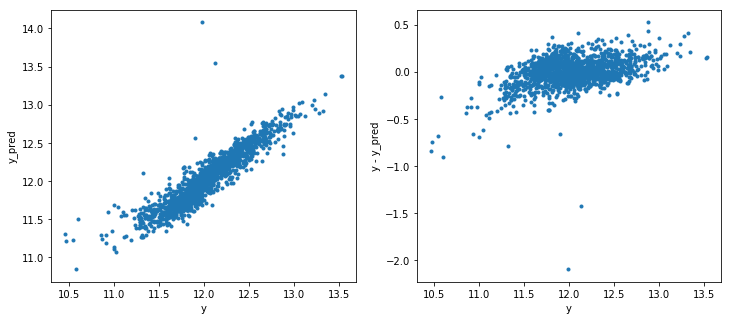

In [37]:
# basic model - LinearRegression on a few numeric features
model_cols = ['SalePrice',
              'OverallQual','GrLivArea','GarageCars','YearBuilt',
              'TotalBsmtSF','YearRemodAdd','Fireplaces','LotArea',
              'ExterQual','BsmtQual','KitchenQual','GarageFinish',
              'FireplaceQu','HeatingQC']

df_model = pd.get_dummies(df_all[model_cols])

df_train = df_model[df_all.index <= maxid_train]

y = df_train.SalePrice
X = df_train.drop('SalePrice',axis=1)

from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X,y)

lr_coefs = pd.Series(lr.coef_,index=X.columns)
print('Intercept     ',lr.intercept_)
print(lr_coefs.sort_values(ascending=False))

y_pred = lr.predict(X)
rms_pred = rmse_log(y_pred, y)
print('R2=',lr.score(X,y))
print('log rmse=',rms_pred)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(y,y_pred,'.')
plt.xlabel('y')
plt.ylabel('y_pred');

plt.subplot(1,2,2)
plt.plot(y,y-y_pred,'.')
plt.xlabel('y')
plt.ylabel('y - y_pred');

Id
524     12.126759
1299    11.982929
Name: SalePrice, dtype: float64
Id                524       1299
OverallQual   1.000000  1.000000
GrLivArea     0.818011  1.000000
GarageCars    0.600000  0.400000
YearBuilt     0.978261  0.985507
TotalBsmtSF   0.513584  1.000000
YearRemodAdd  0.966667  0.966667
Fireplaces    0.250000  0.750000
LotArea       0.181327  0.292538
ExterQual     1.000000  1.000000
BsmtQual      1.000000  1.000000
KitchenQual   1.000000  1.000000
GarageFinish  1.000000  1.000000
FireplaceQu   0.800000  0.800000
HeatingQC     1.000000  1.000000


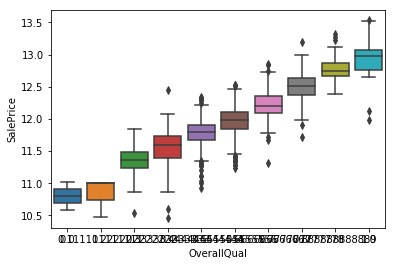

In [38]:
# couple outliers - lower than expected price for 10/10 quality

print(y.loc[y[abs(y-y_pred)>1].index].T)
print(X.loc[y[abs(y-y_pred)>1].index].T)

#print(df_all.loc[y[abs(y-y_pred)>1].index].T)
#df_all.groupby('Neighborhood').SalePrice.mean().sort_values(ascending=False)

sns.boxplot(x='OverallQual',y='SalePrice',data=df_all)

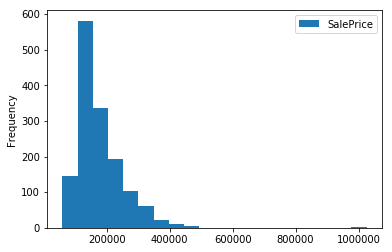

In [39]:
df_test = df_model[df_all.index > maxid_train]

X_test = df_test.drop('SalePrice',axis=1)

X_test.fillna(0,inplace=True)

y_test = lr.predict(X_test)
y_test = np.exp(y_test) # revert log transformation

y_test = pd.DataFrame(y_test,index=X_test.index)
y_test.columns = ['SalePrice']
y_test.to_csv('submission.csv')

y_test.plot.hist(bins=20)